# Small NNC example
A small example to compare NNC with optimal control on a toy dynamical system.

In [ ]:
# To edit source files and automatically refresh code
%load_ext autoreload
%autoreload 2

# Load custom modules path
import sys
sys.path.append('../../')

# Custom modules path
import nnc.controllers.baselines.ct_lti.dynamics as dynamics
import nnc.controllers.baselines.ct_lti.optimal_controllers as oc
from nnc.controllers.neural_network.nnc_controllers import\
     NeuralNetworkController, NNCDynamics

# Computation and plot helpers for this example
from examples.directed.small_example_helpers import EluTimeControl, evaluate_trajectory, todf
from examples.directed.small_example_helpers import compare_trajectories, grand_animation

# progress bar
from tqdm.notebook import tqdm
#tqdm是 Python 进度条库，可以在 Python长循环中添加一个进度提示信息。用户只需要封装任意的迭代器，是一个快速、扩展性强的进度条工具库。

# Other libraries for computing
import torch
import numpy as np
import pandas as pd

# ODE solvers with gradient flow
from torchdiffeq import odeint

# plots
import plotly
plotly.offline.init_notebook_mode()


## Continuous Time Time-Invariant Dynamics
First we define our dynamics as:
\begin{equation}\label{eq:ld}
\dfrac{dx}{dt} = \langle A, x^{\intercal} \rangle + \langle B, u^{\intercal}\rangle
\end{equation}
where:
\begin{align}
x &: \text{a state vector over $N$ nodes.}\\
A &: \text{an $N\times N$ interaction matrix, indicating nodal interactions.}\\
u &: \text{a control signal vector of $M\leq N$ independent control signals.}\\
B &: \text{an $N\times M$ driver matrix, indicating control signal effects on nodes.}\\
\end{align}

In this example we parametrize the system as:

### System Parametrization

\begin{align}
A &= 
\begin{pmatrix}
    1 & 0 \\
    1 & 0 \\
\end{pmatrix}\\
B &= 
\begin{pmatrix}
    1 \\
    0 \\
\end{pmatrix}
\end{align}

Essentially, we evaluate control over a 2-node undirected graph with control signal applied over one node (single driver node).

In [116]:
# Basic setup for calculations, graph, number of nodes, etc.
dtype = torch.float32
device = 'gpu'
training_session = True

# interaction matrix
A = torch.tensor([
    [0., 0., 1.],
    [1., 0., 0.],
    [0., 1., 0.]
])

# driver matrix
B = torch.tensor([
    [1.],
    [0.],
    [0.]
])

B

# interaction matrix dimensions denote how many nodes we have in the network
n_nodes = A.shape[-1]          #3
# column dimension implies the number of driver nodes.
n_drivers = B.shape[-1]     #1

# implementing the dynamics
linear_dynamics = dynamics.ContinuousTimeInvariantDynamics(A, B, dtype, device)    #动力学方程

The exact implementation of the dynamics:

In [117]:
#dynamics.ContinuousTimeInvariantDynamics??

### Experimental Setting
We aim to control the system from initial state $x(0)=(1, 0.5)$ to $x^* = (0,0)$ within time $T=1$.

In [118]:
# total time for control
T = 1
# we evaluate two points in time, first point is matched to initial
# state and  second one is matched to the terminal state
t = torch.linspace(0, T, 2)

# initial state is set as follows, but can be chosen arbirtarily:
x0 = torch.tensor([[
        1., 0., 0.

]])

# same applies for target state:
x_target = torch.tensor([[
    0., 0., 1.
]])

x0

tensor([[1., 0., 0.]])

### Control  Baseline
Here we use the minimum energy optimal control as baseline based on the following work:
- Yan, G., Ren, J., Lai, Y. C., Lai, C. H., & Li, B. (2012). Controlling complex networks: How much energy is needed?. Physical review letters, 108(21), 218703.

For CT-LTI systems that satisfy controllability assumption, this baseline achieves the maximum theoretical performance, i.e. it cannot be surpassed by any other.

In [120]:
# baseline definition   求u*
oc_baseline = oc.ControllabiltyGrammianController(
    alpha = A,
    beta = B,
    t_infs = T,
    x0s = x0, # a batch with one sample
    x_infs = x_target, # a batch with one sample 
    simpson_evals = 100,
    progress_bar=None,
    use_inverse=False,
)


ControllabiltyGrammianController()

Below, we create on line 2 a `lambda` expression function to make the dynamics compatible with required method signatue, and then we evolve the system with `odeint` method from `torchdiffeq` package (line 3).
The result of `odeint` is a tensor of shape `[timesteps, state_size]`.
The reached state corresponds to the last index of the result `[-1]`.
As we print on line 4, optimal control reached the target state after control $x(T)\approx x^*$.

In [123]:
timesteps = torch.linspace(0, T, 2)    #tensor([0,1])
oc_dynamics = lambda t,x: linear_dynamics(t, x, oc_baseline(t, x))
xT_oc = odeint(oc_dynamics, x0.unsqueeze(0), t=timesteps)[-1]    #求解方程后，取最后时刻T的解，即最优控制的位置
print(str(xT_oc.flatten().detach().cpu().numpy()))    #3维变1维
xT_oc2 = odeint(oc_dynamics, x0.unsqueeze(0), t=timesteps)
xT_oc2 

[-2.4720061e-05 -1.3312408e-06  9.9999964e-01]


tensor([[[[ 1.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[-2.4720e-05, -1.3312e-06,  1.0000e+00]]]])

### Neural Network Control
We define a custom neural network for learning contro.
In this example we pick a fully connected architecture with 2 layers of n+4 neurons
and expotential linear unit activation.
The content of the class can be found below:

In [124]:
#EluTimeControl??

We define a training routine for the neural networks.
- Note the `x0.detach()` and `t.detach()` on lines 7,8 respectively to avoid unexpected gradient flows.
- It is important is to notice on the next cell, in line 11 that we include no energy regularization term in the loss.
- We then do the backpropagation with autograd on line 13 and then let the optimizer (Adam) to update the network parameters.
- We prefer to train with variable step method `dopri5` on line 8, but we evaluate with constant step size on line 16, to limit performance advantages due to step size selection.

In [125]:
from copy import deepcopy
def train(nnc_dyn, epochs, lr, t, n_timesteps=40): #simple training
    optimizer = torch.optim.Adam(nnc_dyn.parameters(), lr=lr)
    trajectories = [evaluate_trajectory(linear_dynamics, 
                                         nnc_dyn.nnc, 
                                         x0, 
                                         T, 
                                         n_timesteps, 
                                         method='rk4',
                                         options=dict(step_size = T/n_timesteps)
                                        )] # keep trajectories for plots
    parameters = [deepcopy(dict(nnc_dyn.nnc.named_parameters()))]       #dict字典，以键值对保存；deepcopy深度复制
    
    for i in tqdm(range(epochs)):
        optimizer.zero_grad() # do not accumulate gradients over epochs
        
        x = x0.detach()
        x_nnc = odeint(nnc_dyn, x, t.detach(), method='dopri5')
        x_T = x_nnc[-1, :] # reached state at T
        
        loss = ((x_target - x_T)**2).sum() # !No energy regularization

        loss.backward()
        optimizer.step() 

        trajectory = evaluate_trajectory(linear_dynamics, 
                                         nnc_dyn.nnc, 
                                         x0, 
                                         T, 
                                         n_timesteps, 
                                         method='rk4',
                                         options=dict(step_size = T/n_timesteps)
                                        )
        
        if i%1000 == 0:
            parameters.append(deepcopy(dict(nnc_dyn.nnc.named_parameters())))
            trajectories.append(trajectory)
    return torch.stack(trajectories).squeeze(-2), parameters

## Experimental Results
We can now apply training, collect trajctories and save the model.
Notice that we decrease learning rate on lines 11 and 14.
NNC is very sensitive to learning rate and often requires several lr-adapaptions to converge to desirable performance.
Such, adaptions can be automated as discussed in the paper.

In [ ]:
n_timesteps = 60 #relevant for plotting, ode solver is variable step
linear_dynamics = dynamics.ContinuousTimeInvariantDynamics(A, B, dtype, device)

if training_session:
    torch.manual_seed(0)
    neural_net = EluTimeControl(n_nodes, n_drivers)  #n_nodes+17为网络结构隐藏层节点个数，n_drivers输出层节点个数，建网络模型
    nnc_model = NeuralNetworkController(neural_net)
    nnc_dyn = NNCDynamics(linear_dynamics, nnc_model)
    # time to train now:
    t = torch.linspace(0, T, n_timesteps)
    #t1 = train(nnc_dyn, 10, 0.1, t) # , 200 epochs, learning rate 0.1
    #df1 = todf(t1, lr=0.1)
    t2, parameters = train(nnc_dyn, 20000, 0.0006, t) # , 100 epochs, learning rate 0.01。t2的torch.Size([2, 40, 4])
    df2 = todf(t2, lr=0.0025)
    torch.save(neural_net, 'trained_elu_net_directed.torch')
    alldf = pd.concat([df2], ignore_index=True)
    
    alldf.to_csv('all_trajectories_directed.csv')   
else: 
    neural_net = torch.load('trained_elu_net_directed.torch')
    alldf = pd.read_csv('all_trajectories_directed.csv', index_col=0)
    nnc_model = NeuralNetworkController(neural_net)
    nnc_dyn = NNCDynamics(linear_dynamics, nnc_model)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
 nnc_dyn



In [10]:
parameters[0]

{'neural_net.neural_net.linear.weight': Parameter containing:
 tensor([[-0.0075],
         [ 0.5364],
         [-0.8230],
         [-0.7359],
         [-0.3852],
         [ 0.2682],
         [-0.0198],
         [ 0.7929],
         [-0.0887],
         [ 0.2646],
         [-0.3022],
         [-0.1966],
         [-0.9553],
         [-0.6623],
         [-0.4122],
         [ 0.0370],
         [ 0.3953],
         [ 0.6000],
         [-0.6779],
         [-0.4355]], requires_grad=True),
 'neural_net.neural_net.linear.bias': Parameter containing:
 tensor([ 0.3632,  0.8304, -0.2058,  0.7483, -0.1612,  0.1058,  0.9055, -0.9277,
         -0.6295, -0.2532, -0.3898,  0.8640, -0.6482, -0.4603, -0.6986, -0.9366,
         -0.5837,  0.8596,  0.4462,  0.4847], requires_grad=True),
 'neural_net.neural_net.linear0.weight': Parameter containing:
 tensor([[ 0.0118, -0.1146,  0.0378, -0.2088, -0.1616, -0.1153,  0.1411,  0.1311,
          -0.0992, -0.0081,  0.1430,  0.2223,  0.0887,  0.0302,  0.1499, -0.1317,


Now we can check the reached for NNC, and as we observe it is close to the target.
More epochs on lower learnig rates will further improve this result.

In [12]:
t = torch.linspace(0, T, 2)
x = x0.detach()
ld_controlled_lambda = lambda t, x_in: linear_dynamics(t, u=neural_net(t, x_in), x=x_in)
x_all_nn = odeint(ld_controlled_lambda, x0, t, method='rk4', 
                  options = dict(step_size=T/n_timesteps))
x_T = x_all_nn[-1, :]
#x_all_nn.size()
print(str(x_T.flatten().detach().cpu().numpy()))



'''x_all_nn.size(([2, 1, 3]))
tensor([[[ 1.0000,  0.0000,  0.0000]],

        [[-0.1002,  0.4282,  0.3066]]],
因为只有两个时刻的值（对应2），取T时刻也就是最优控制时刻的解[-0.10017395  0.4282443   0.30658346]'''


[9.3024969e-04 4.6441006e-04 1.0001243e+00]


'x_all_nn.size(([2, 1, 3]))\ntensor([[[ 1.0000,  0.0000,  0.0000]],\n\n        [[-0.1002,  0.4282,  0.3066]]],\n因为只有两个时刻的值（对应2），取T时刻也就是最优控制时刻的解[-0.10017395  0.4282443   0.30658346]'

In [13]:
t = torch.linspace(0, T, 20)
x = x0.detach()
ld_controlled_lambda = lambda t, x_in: linear_dynamics(t, u=neural_net(t, x_in), x=x_in)
x_all_nn = odeint(ld_controlled_lambda, x0, t, method='rk4', 
                  options = dict(step_size=T/n_timesteps))
x_T = x_all_nn[-1, :]
#x_all_nn.size()
print(str(x_T.flatten().detach().cpu().numpy()))



'''x_all_nn.size(([2, 1, 3]))
tensor([[[ 1.0000,  0.0000,  0.0000]],

        [[-0.1002,  0.4282,  0.3066]]],
因为只有两个时刻的值（对应2），取T时刻也就是最优控制时刻的解'''


[9.3024969e-04 4.6441006e-04 1.0001243e+00]


'x_all_nn.size(([2, 1, 3]))\ntensor([[[ 1.0000,  0.0000,  0.0000]],\n\n        [[-0.1002,  0.4282,  0.3066]]],\n因为只有两个时刻的值（对应2），取T时刻也就是最优控制时刻的解'

In [14]:
def parameter_norm_difference(n_prev, n_now):
    assert n_prev.keys() == n_now.keys()
    norm = 0

    for (k,v) in n_prev.items():
        #print(k)
        norm += ((v.detach() - n_now[k].detach())**2).sum()
    #k = 'neural_net.neural_net.linear_final.weight'
    #norm = ((n_prev[k].detach() - n_now[k].detach())**2).sum()
    return (norm).cpu().detach().item()


def parameter_square_l2(param):
    norm = 0

    for (k,v) in param.items():
        norm += ((v.detach())**2).sum()
    #k = 'neural_net.neural_net.linear_final.weight'
    #norm = ((n_prev[k].detach() - n_now[k].detach())**2).sum()
    return (norm).cpu().detach().item()


In [15]:
def parameter_norm_difference(n_prev, n_now):
    assert n_prev.keys() == n_now.keys()
    norm = 0

    for (k,v) in n_prev.items():
        #print(k)
        norm += ((v.detach() - n_now[k].detach())**2).sum()
    #k = 'neural_net.neural_net.linear_final.weight'
    #norm = ((n_prev[k].detach() - n_now[k].detach())**2).sum()
    return (norm).cpu().detach().item()


def parameter_square_l2(param):
    norm = 0

    for (k,v) in param.items():
        norm += ((v.detach())**2).sum()
    #k = 'neural_net.neural_net.linear_final.weight'
    #norm = ((n_prev[k].detach() - n_now[k].detach())**2).sum()
    return (norm).cpu().detach().item()


In [52]:
w_diff = [parameter_norm_difference(parameters[i], parameters[i+1])
          for i in range(len(parameters)-1)]
'''
len(parameters)=2,分为初值和终值两种，每种里面由权重和偏差
'''
w_l2 = [parameter_square_l2(param) for param in parameters]


u_diff = []
en_all = []
n_points=40
for sid in alldf['sample_id'].unique():
    if sid < alldf['sample_id'].max():
        dat_0 = alldf[alldf['sample_id'] == sid].sort_values('time')
        dat_1 = alldf[alldf['sample_id'] == sid+1].sort_values('time')

        diff = ((dat_0['u'].values-dat_1['u'].values)**2).sum()
        u_diff.append(diff)
        en_all.append((dat_0['u'].values**2*T/n_timesteps).sum())


print(len(w_diff))
w_diff = np.array(w_diff)
u_diff = np.array(u_diff)

np.savetxt("norm_diffs_directed.csv", np.c_[w_diff,u_diff])

#w_diff[w_diff > np.quantile(w_diff, 0.99)] = np.nan
#u_diff[u_diff > np.quantile(u_diff, 0.99)] = np.nan
#w_diff = w_diff/w_diff.max()
#u_diff = u_diff/u_diff.max()
dfff = pd.DataFrame(dict(u_d = u_diff,  w_d = w_diff))
a = dfff.dropna()


a['u_d'] = (a['u_d']-a['u_d'].min())/(a['u_d'].max()-a['u_d'].min())
a['w_d'] = (a['w_d']-a['w_d'].min())/(a['w_d'].max()-a['w_d'].min())
from nnc.helpers.plot_helper import trendplot
from examples.directed.small_example_helpers import base_temp, axis_temp

fig_c = trendplot(a['u_d'].tolist(),a['w_d'].tolist(),
                r'$||\Delta u||_2^2$', r'$||\Delta w||_2^2$'  )

'''fig_c.layout.annotations[0].x=0.6
fig_c.layout.annotations[0].y=-0.1
fig_c.layout.annotations[0].xref='x'
fig_c.layout.annotations[0].yref='y'
fig_c.layout.annotations[0].align="right"'''

fig_c.layout.width = 170
fig_c.layout.height = 150
fig_c.layout.margin.l = 35
fig_c.layout.margin.t = 0
fig_c.layout.margin.b = 25
fig_c.layout.margin.r = 0
fig_c.layout.font.size = 10
fig_c.update_layout(base_temp)
fig_c.update_xaxes(axis_temp)
fig_c.update_yaxes(axis_temp)
#fig_c.write_image('corr_plot_w_u.png')
fig_c.show()
 


20


In [53]:
wl2 = np.array(w_l2)
ul2 = np.array(en_all)

np.savetxt("norm_evolution_directed.csv", np.c_[wl2[:-1], ul2])

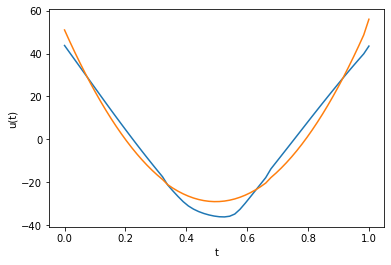

In [54]:
import matplotlib.pyplot as plt
trajectory = evaluate_trajectory(linear_dynamics,
                                     oc_baseline,
                                     x0,
                                     T,
                                     n_timesteps,
                                     method='rk4',
                                     options=dict(step_size=T / n_timesteps)
                                     )
oc_trajectory = np.array(trajectory.squeeze(1).unsqueeze(0))[0]

#np.savetxt("oc_trajectory_directed5.csv", np.c_[oc_trajectory])

trajectory = evaluate_trajectory(linear_dynamics,
                                 nnc_model,
                                 x0,
                                 T,
                                 n_timesteps,
                                 method='rk4',
                                 options=dict(step_size=T / n_timesteps)
                                 )
nnc_trajectory = trajectory.squeeze(1).unsqueeze(0).detach().numpy()[0]

#np.savetxt("nnc_trajectory_directed5.csv", np.c_[nnc_trajectory])

nnc_u = np.array([nnc_trajectory[i,3] for i in range(len(nnc_trajectory))])
oc_u = np.array([oc_trajectory[i,3] for i in range(len(oc_trajectory))])

energy_nnc = np.cumsum((nnc_u**2)*T/n_timesteps)
energy_oc = np.cumsum((oc_u ** 2) * T / n_timesteps)

time = np.linspace(0,T,n_timesteps)

#np.savetxt("energies_directed5.csv", np.c_[time, energy_nnc, energy_oc])

plt.figure()
#plt.plot(time,energy_oc)
#plt.plot(time,energy_nnc)
plt.plot(time,nnc_u)
plt.plot(time,oc_u)
plt.xlabel(r"t")
plt.ylabel(r"u(t)")
plt.show()


In [55]:
n_points

40

In [56]:
import plotly.express as px
from plotly.subplots import make_subplots

wl2dat = px.line(y=ul2).data[0]
wl2dat.name = r'$||w||_2^2$'
wl2dat.showlegend = True


wl2dat.yaxis = 'y2'
wl2dat.line.color = 'orange'


ul2dat = px.line(y=wl2).data[0]
ul2dat.name = r'$||u||_2^2$'
ul2dat.showlegend = True

In [46]:
from plotly import graph_objects as go
fig_d = make_subplots(specs=[[{"secondary_y": True}]])
fig_d.add_trace(ul2dat)
fig_d.add_trace(wl2dat, secondary_y=True)
fig_d.update_layout(base_temp)
fig_d.update_xaxes(axis_temp)
fig_d.update_yaxes(axis_temp)
fig_d.layout.xaxis.title = r'$\tau$'
fig_d.layout.yaxis1.title = r'$||u||_2^2$'
fig_d.layout.yaxis2.title = r'$||w||_2^2$'

fig_d.layout.width = 195
fig_d.layout.height = 150
fig_d.layout.margin.l = 35
fig_d.layout.margin.t = 0
fig_d.layout.margin.b = 0
fig_d.layout.margin.r = 35

fig_d.update_layout(legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.01,
        xanchor="right",
        x=0.96,
       font=dict(
            family="Courier",
            size=9,
            color="black"
        ),
        itemsizing = 'trace',
            bgcolor="rgba(255,255,255,0.0)",

    ))
#fig_d.write_image('norms.pdf')
fig_d.show()

NameError: name 'axis_temp' is not defined

In [21]:
ocdata = evaluate_trajectory(
    linear_dynamics,
    oc_baseline,
    x0,
    T,
    n_timesteps,
    method='rk4',
    options=None,
)

nncdata = evaluate_trajectory(
    linear_dynamics,
    nnc_model,
    x0,
    T,
    n_timesteps,
    method='rk4',
    options=None,
)

all_controls = pd.DataFrame(dict(oc=ocdata[:, 0, -1].detach().cpu().numpy(),
                                 nnc=nncdata[:, 0, -1].detach().cpu().numpy()))


fig_e = trendplot(all_controls['nnc'],all_controls['oc'],
                'OC', 'NNC'  )

fig_e.layout.annotations[0].x=2
fig_e.layout.annotations[0].y=-6
fig_e.layout.annotations[0].xref='x'
fig_e.layout.annotations[0].yref='y'
fig_e.layout.annotations[0].align="right"

fig_e.layout.width = 170
fig_e.layout.height = 150
fig_e.layout.margin.l = 35
fig_e.layout.margin.t = 0
fig_e.layout.margin.b = 25
fig_e.layout.margin.r = 0
fig_e.layout.font.size = 12
fig_e.update_layout(base_temp)
fig_e.update_xaxes(axis_temp)
fig_e.update_yaxes(axis_temp)
#fig_e.write_image('corr_plot_controls.pdf')
fig_e.show()

NameError: name 'trendplot' is not defined

In [22]:
losses = (alldf[alldf['reached'] == True][['x1','x2']]**2).sum(1)

In [23]:
fig_g = px.line(y=losses)

fig_g.layout.width = 185
fig_g.layout.height = 150
fig_g.layout.margin.l = 35
fig_g.layout.margin.t = 0
fig_g.layout.margin.b = 0
fig_g.layout.margin.r = 0
fig_g.layout.font.size = 12
fig_g.update_layout(base_temp)
fig_g.update_xaxes(axis_temp)
fig_g.update_yaxes(axis_temp)
fig_g.layout.xaxis.title = r'$\tau$'
fig_g.layout.yaxis.title = r'MSE'
fig_g.layout.yaxis.type='log'
fig_g.layout.yaxis.exponentformat = 'power'
#fig_g.write_image('losses.pdf')
fig_g

Now we compare NNC to optimal control (OC) in terms of: (i) controlled trajectories (left) and (ii) total energy (right). As we see both methods are extremely close.

SyntaxError: invalid syntax (<ipython-input-23-e6a91187d7ce>, line 20)

In [24]:
fig_comparison, fig_a, fig_b = compare_trajectories(linear_dynamics,
                     oc_baseline,
                     nnc_model,
                     x0,
                     x_target,
                     T,
                     x1_min=-3,
                     x1_max=3,
                     x2_min=-1.5,
                     x2_max=1.5,
                     n_points=40,
                    )
#fig_comparison

RuntimeError: Expected tensor to have size 3 at dimension 1, but got size 2 for argument #2 'batch2' (while checking arguments for bmm)

In [25]:
fig_b = fig_b.update_layout(base_temp)
fig_b.layout.xaxis2 = axis_temp
fig_b.layout.yaxis2 = axis_temp
fig_b.layout.xaxis2.title = r"$t$"
fig_b.layout.yaxis2.title = "Total Energy"


fig_b.data[0].showlegend = True
fig_b.data[1].showlegend = True

fig_b.layout.width = 165
fig_b.layout.height = 150
fig_b.layout.margin.l = 35
fig_b.layout.margin.t = 0
fig_b.layout.margin.b = 0
fig_b.layout.margin.r = 0

fig_b.update_layout(legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.01,
        xanchor="right",
        x=1,
       font=dict(
            family="Courier",
            size=12,
            color="black"
        ),
        itemsizing = 'trace',
            bgcolor="rgba(255,255,255,0.6)",

    ))
#fig_b.write_image('energy.pdf')

fig_b

NameError: name 'fig_b' is not defined

In [26]:
fig_a.data[0].showlegend = False
fig_a.data[1].mode = 'markers'
#a.data[1].text = r"x(0)"
fig_a.data[1].marker.size = 5
fig_a.data[2].marker.size = 5
fig_a.data[1].showlegend = False
fig_a.data[2].showlegend = False
fig_a.data[3].showlegend = False
fig_a.data[4].showlegend = False



fig_a.data[3].line.width = 2
fig_a.data[4].line.width = 2

fig_a.layout.xaxis.range = [-1.3, 1.3]
fig_a.layout.yaxis.range = [-0.1, 0.7]

fig_a.layout.width = 165
fig_a.layout.height = 150
fig_a.layout.margin.l = 35
fig_a.layout.margin.t = 0
fig_a.layout.margin.b = 0
fig_a.layout.margin.r = 0
fig_a.update_layout(legend=dict(
        orientation="v",
        yanchor="bottom",
        y=0.2,
        xanchor="right",
        x=1,
       font=dict(
            family="Courier",
            size=10,
            color="black"
        ),
        itemsizing = 'trace',
            bgcolor="rgba(255,255,255,0.6)",

    ))
#fig_a.write_image('trajectories.pdf')

fig_a.add_annotation(
        x=0.9,
        y=0.44,
        xref="x",
        yref="y",
        text=r"$x(0)$",
        showarrow=False,
        font=dict(
            family="Courier New, monospace",
            size=9,
            ),
        align="center",
        bgcolor="rgba(255,255,255, 0.8)",
        )
fig_a.add_annotation(
        x=0.3,
        y=0.04,
        xref="x",
        yref="y",
        text=r"$x^*$",
        showarrow=False,
        font=dict(
            family="Courier New, monospace",
            size=9,
            ),
        align="center",
        bgcolor="rgba(255,255,255, 0.8)",
        )

fig_a.layout.xaxis.title = r"$x_1\small{(Controlled)}$"
#fig_a.write_image('trajectory.pdf')
fig_a.layout.width = 1000
fig_a.layout.height = 1000
fig_a

NameError: name 'fig_a' is not defined

Finally we animate the learning effort of NNC through the training process. We observe how it slowly converges to the OC trajectory, both in terms of state values and energy.

In [27]:
animation =  grand_animation(alldf,
                             linear_dynamics, 
                             oc_baseline, 
                             nnc_model, 
                             x0,
                             x_target, 
                             T,
                            frame_duration=50) # 50-100 should be ok.
animation

../..\examples\directed\small_example_helpers.py:331: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



RuntimeError: Expected tensor to have size 3 at dimension 1, but got size 2 for argument #2 'batch2' (while checking arguments for bmm)

## Conclusion
This notebook gave us a quick yet insightful demonstration of NNC and its performance compared to optimal control.
Results conclude that NNC is a capable controlled and that it also is equipped with implicit energy regularization.
Still, larger scale demonstrations on complex dynamics will follow to showcase more realistic scenarios, as done alredy in the paper.

In [28]:
def calculate(p_1, p_2):
    for

SyntaxError: invalid syntax (<ipython-input-28-d85a12f4bad8>, line 2)

In [29]:
ocdata = evaluate_trajectory(
    linear_dynamics,
    oc_baseline,
    x0,
    T,
    n_timesteps=100,
    method='rk4',
    options=None,
)

nncdata = evaluate_trajectory(
    linear_dynamics,
    nnc_model,
    x0,
    T,
    n_timesteps=100,
    method='rk4',
    options=None,
)


u_all = nncdata[:, :, -1]


In [30]:
uu = (u_all @ u_all.transpose(1,0))
uu = uu*(torch.ones_like(uu) - torch.ones(uu.shape[0]).diag())

In [31]:
uu.sum()

tensor(-53429.2500, grad_fn=<SumBackward0>)

In [32]:
((u_all)**2).sum()

tensor(64590.5352, grad_fn=<SumBackward0>)

In [33]:
timesteps = torch.linspace(0, T, u_all.shape[0])

In [34]:
dxx = linear_dynamics(t, nncdata[:, :, [0,1]].detach(), u_all)

RuntimeError: Expected tensor to have size 3 at dimension 1, but got size 2 for argument #2 'batch2' (while checking arguments for bmm)

In [35]:
forces = (dxx[:, 0] - u_all[:, 0])

NameError: name 'dxx' is not defined

In [36]:
x_d = x_target - x0

In [37]:
eta =  T/uu.shape[0]
(x_d[:, 0] - eta*forces.sum())*uu.sum()*eta

NameError: name 'forces' is not defined

In [38]:
u_all.shape

torch.Size([100, 1])

In [39]:
y = alldf[alldf['reached']==True]['energy']
nncline = px.line(y=y).data[0]
nncline.showlegend=True
nncline.line.color = 'red'
ocline = px.line(y=[en2[-1]]*len(y)).data[0]
nncline = px.line(y=y).data[0]
nncline.showlegend=True
nncline.line.color = 'blue'

go.Figure([nncline, ocline])

NameError: name 'en2' is not defined

In [40]:
en2 = ((ocdata2[:, 0, -1]**2)*(T/ocdata2.shape[0])).cumsum(-1)

NameError: name 'ocdata2' is not defined

In [41]:
ocdata2 = evaluate_trajectory(
    linear_dynamics,
    oc_baseline,
    x0,
    T,
    n_timesteps=40,
    method='rk4',
    options=None,
)

In [42]:
en2

NameError: name 'en2' is not defined